In [69]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Based on the earthquake cycle code: 

Created on Mon Nov 25 09:48:34 2019

Dimensional line fault obeying rate and state friction with Velocity cutoff (Hawthorne and Rubin 2013)

@author: amt
"""

import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt


In [70]:
def setopts():
    o={}
    plots=1
    o['G']=30e9 # rigidity (Pa)
    o['nu']=0.25  # Poisson Ratio
    o['vpl']=1e-8 # plate velocity (m/s)
    o['a']=0.003 # frictional parameter a
    o['b']=0.01 # frictional parameter b
    o['dc']= 0.02 # weakening distance (m)
    o['vs']=3e3 # shear wave velocity (m/s)
    o['sl']=1 # slip law or ageing law
    o['W']= 60000 # asperity size (m)
    o['WpoW']=5 # this is W'/W (must be odd)
    o['gridfac']=6 # this is what you add to either side to make the FFT from -inf to inf
    o['gridlength']=(2*o['gridfac']+o['WpoW'])*o['W'] # simulation space (m) 
    o['sigma']=5000000; # effective normal stress in Pa
    o['vc_ssz']= 1e-8 # m/sec
    o['Lb']=o['G']*o['dc']/(o['sigma']*o['b']); # L_b
    o['hstar']=o['b']/(o['b']-o['a'])*o['Lb'] # L_(b-a)
    o['Linf']=1/np.pi*(o['b']/(o['b']-o['a']))**2*o['Lb']
    o['eta']=o['G']/(2*o['vs']) # radiation damping (Pa-s/m)  
    if o['sl']==1:
        o['dx']=o['Lb']/20; # cell size (m) for slip law
    else:
        o['dx']=o['Lb']/10; # cell size (m) for ageing law
    if np.mod(o['W']/o['dx'],1)!=0:
        tmp=np.ceil(o['W']/o['dx']);
        o['dx']=o['W']/tmp;
    o['WN']=int(o['W']/o['dx']);
    o['N']=int(o['gridlength']/o['dx']); # number of cells         
    o['X']=np.arange(-(o['gridfac']+np.floor(o['WpoW']/2))*o['W'], ((o['gridfac']+(o['WpoW']-np.floor(o['WpoW']/2)))*o['W']), o['dx']).T    
    o['Wstart']=np.where(o['X']==0)[0]  # index of start of fault position (i.e. 0)
    if len(o['Wstart'])==0:
        o['Wstart']=int(np.where(abs(o['X'])==np.min(abs(o['X'])))) # this deals with irrational o.dx
    else:
        o['Wstart']=int(o['Wstart'][0])
    o['Wend']=o['Wstart']+int(o['W']/o['dx'])-1 # end of fault position (i.e.0) 
    o['Fstart']=int(o['Wstart']-np.floor(o['WpoW']/2)*o['WN'])
    o['Fend']=int(o['Wend']+np.floor(o['WpoW']/2)*o['WN'])   
    o['k']=abs(2*np.pi*np.arange(-o['N']/2,o['N']/2))/((o['gridlength']-o['dx'])) # wavenumber vector
    o['aoverb']=o['b']/o['a']*np.ones((o['N'])) 
    o['aoverb'][o['Wstart']:o['Wend']] = o['a']/o['b']
    o['agrid']=o['aoverb']*o['b']
    o['bgrid']=o['a']/o['aoverb']
    
    
    end_x_ssz = int( 20000./o['dx'])
    
    o['vcgrid']= 1 * np.ones((o['N']))  # cutoff velocity (m/s)
    o['vcgrid'][ o['Wstart'] : o['Wstart'] + end_x_ssz ]= 1 * o['vpl'] # cutoff velocity (m/s)

    o['dcgrid']= 0.04 * np.ones((o['N'])) ; # effective normal stress in Pa
    o['dcgrid'][o['Wstart'] : o['Wstart'] + end_x_ssz ]= 0.004
        
    
    if plots:
        fig, axs = plt.subplots(2, sharex=True)       
        axs[0].plot(o['X'],o['aoverb'],color='black', linestyle='--')
        axs[0].axvline(x=o['X'][o['Wstart']],color='blue')
        axs[0].text(o['X'][o['Wstart']],1,'Wstart',rotation=90,color='blue')
        axs[0].axvline(x=o['X'][o['Wend']],color='blue')
        axs[0].text(o['X'][o['Wend']],1,'Wend',rotation=90,color='blue')
        axs[0].axvline(x=o['X'][o['Fstart']],color='red')
        axs[0].text(o['X'][o['Fstart']],1,'Fstart',rotation=90,color='red')
        axs[0].axvline(x=o['X'][o['Fend']],color='red')
        axs[0].text(o['X'][o['Fend']],1,'Fend',rotation=90,color='red')
        axs[0].set_ylabel('a/b')
        axs[1].plot(o['X'],np.ones(len(o['X']))*o['sigma'],color='black', linestyle='--')
        axs[1].axvline(x=o['X'][o['Wstart']],color='blue')
        axs[1].axvline(x=o['X'][o['Wend']],color='blue')
        axs[1].axvline(x=o['X'][o['Fstart']],color='red')
        axs[1].axvline(x=o['X'][o['Fend']],color='red')
        axs[1].set_ylabel('Sigma (Pa)')

       
    return o

def getstress(v,o):
    fftx = np.fft.fftshift(np.fft.fft(v))
    df = np.fft.ifft(np.fft.ifftshift(o['k']*fftx))
    return df

# ODEs to solve
def ratestate_sl(t,y,o):
    """
    Defines the differential equations for the coupled spring-mass system.
    Arguments:
        t :  time
        y :  vector of the state variables [theta,velocity,slip,]
        o :  structure with parameters
    """
    State=y[:o['N']]
    Vel=y[o['N']:2*o['N']] 
    Disp=y[2*o['N']:3*o['N']]
    # Slip law
    dStatedt =  np.concatenate((np.zeros(o['Fstart']),
        -State[o['Fstart']:o['Fend']]*Vel[o['Fstart']:o['Fend']]/o['dcgrid'][o['Fstart']:o['Fend']]*np.log(State[o['Fstart']:o['Fend']]*Vel[o['Fstart']:o['Fend']]/o['dcgrid'][o['Fstart']:o['Fend']]),
        np.zeros(o['N']-o['Fend'])))
    stress=getstress(Vel,o);
    dVeldt = np.concatenate((np.zeros(o['Fstart']),
        (o['agrid'][o['Fstart']:o['Fend']]/Vel[o['Fstart']:o['Fend']] + o['eta']/o['sigma'])**(-1)*
        (-o['bgrid'][o['Fstart']:o['Fend']]*o['vcgrid'][o['Fstart']:o['Fend']]*dStatedt[o['Fstart']:o['Fend']]/(o['vcgrid'][o['Fstart']:o['Fend']]*State[o['Fstart']:o['Fend']]+o['dcgrid'][o['Fstart']:o['Fend']]) - o['G']/o['sigma']*stress[o['Fstart']:o['Fend']]/2),
        np.zeros(o['N']-o['Fend'])))
    dDispdt = Vel
    dy = np.concatenate((dStatedt,dVeldt,dDispdt))

    return dy


Solver running..............wait
Time steps complete


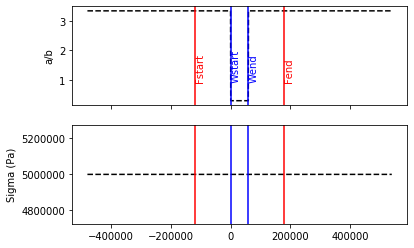

In [71]:
## Set parameters
o=setopts()

## Initial conditions
plots=1;
seed=2;
State = o['dc']/o['vpl']*np.concatenate((np.ones(o['Wstart']), 2*np.ones(o['Wend']-o['Wstart']), np.ones(o['N']-o['Wend']))) # initial state 
Vel = o['vpl']*np.concatenate((np.ones(o['Wstart']), 1/seed*np.ones(o['Wend']-o['Wstart']), np.ones(o['N']-o['Wend']))) # initial velocity 
Disp = np.zeros(np.shape(Vel)) # initial slip (m)
y0=np.concatenate((State,Vel,Disp))
print('Solver running..............wait')

# Call the ODE solver.
if o['sl']:
    wsol = solve_ivp(lambda t, y: ratestate_sl(t, y, o), [0,3e8], y0, max_step=1000000, rtol=10e-10, atol=10e-10)
else:
    wsol = solve_ivp(lambda t, y: ratestate_al(t, y, o), [0,2e7], y0, max_step=1000000, rtol=10e-10, atol=10e-10)

print('Time steps complete') 

800 866.0 899
3 [6606, 13161, 19880]


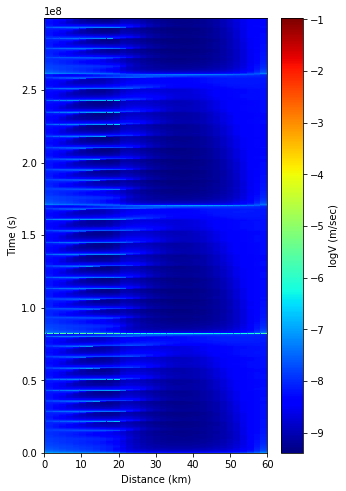

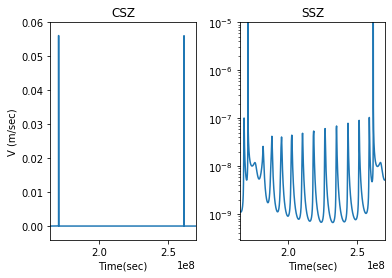

In [72]:
start_x_csz = int( 20000./o['dx']) + o['Wstart']

print (o['Wstart'] , (start_x_csz + o['Wend'] ) /2.0 ,  o['Wend'] )

co_seism_midpoint = int(  (start_x_csz + o['Wend'] ) /2.0 )
ssz_midpoint =   o['Wstart'] + int( 10000./o['dx']) 


cycles_time =  np.where( wsol.y[co_seism_midpoint +o['N'],:] > 0.01)

cycle_time = []
number_of_cycles = 0

for i in range(np.shape(cycles_time)[1] -1 ):
    if (cycles_time[0][i+1] - cycles_time[0][i] > 2):
        cycle_time. append(cycles_time[0][i+1] )
        number_of_cycles = number_of_cycles + 1 

print (number_of_cycles, cycle_time )


#Plot the result
fig, ax = plt.subplots(figsize=(5,8))
x = wsol.t[::5]
y = o['X'][o['Fstart']:o['Fend']]
X, Y = np.meshgrid(x, y)
vel = wsol.y[o['Fstart']+o['N']:o['Fend']+o['N'],::5]
cs = ax.pcolormesh(Y[::3,:]/1e3, X[::3,:], np.log10(vel)[::3,:], cmap='jet')
cbar = fig.colorbar(cs)
plt.ylabel('Time (s)')
plt.xlabel('Distance (km)')
plt.xlim([0,60])
cbar.ax.set_ylabel('logV (m/sec)')

fig,(ax1,ax2) = plt.subplots(1,2) 


ax1.plot( wsol.t, wsol.y[co_seism_midpoint +o['N'],:] )
ax1.set_xlim([1.5e8,2.8e8])
ax1.set_ylim(ymax=0.06)
ax2.semilogy( wsol.t, wsol.y[ssz_midpoint +o['N'],:] ) 
ax1.set_xlim([1.65e8,2.7e8])
ax2.set_ylim(ymax=1e-5)
ax2.set_xlim([1.65e8,2.7e8])
plt.subplots_adjust(wspace=0.3)
ax1.set_xlabel('Time(sec)')
ax1.set_ylabel('V (m/sec)')
ax2.set_xlabel('Time(sec)')
ax1.set_title('CSZ')
ax2.set_title('SSZ')
plt.show()
